# Hospital Inpatient Discharges (SPARCS De-identified): 2017
Source: New York State Health Department
https://health.data.ny.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/22g3-z7e7

Goal is to predict Risk of Mortality to better inform treatment, aggressiveness of approach, expectations of family...

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Using Hospital Inpatient Discharge information for the State of New York from 2017

df= pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv', low_memory= False)

In [3]:
print(df.shape)
df.head()

(2343569, 34)


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Medicare,Self-Pay,NaN,N,N,114168.00,40464.04
1,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,58517.00,26046.50
2,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,...,Moderate,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,39647.04,17397.59
3,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,36031.09,16118.84
4,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,...,Minor,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,30534.00,11921.05


## Exploration of target

**The target that I want to predict is APR Risk of Mortality.**

This is an important target as it will dictate certain decisions such as treatments, aggresiveness of care, allocation of hospital resources, familial preparations for the worst outcome etc...
- Ordinal rank Minor(1), Moderate(2), Major(3), Extreme(4)

It is important to determine this metric early on in the process of treating the patient as this is a crucial piece of information in creating efficient and effective treatment plans for higher risk patients.

As such, while doing feature selection we will consider the time frame of when certain features are available in order to implement the model earlier in the inpatient process.

In [4]:
# Label encode
df['APR Risk of Mortality'] = df['APR Risk of Mortality'].replace({
    'Minor': 1,
    "Moderate": 2,
    "Major": 3,
    "Extreme": 4
})

In [5]:
# Target is 'APR Risk of Mortality'

# Look at target statistics
df['APR Risk of Mortality'].describe()

count    2.343329e+06
mean     1.691481e+00
std      9.164827e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: APR Risk of Mortality, dtype: float64

In [6]:
# Value counts

df['APR Risk of Mortality'].value_counts()

1.0    1338452
2.0     508068
3.0     378128
4.0     118681
Name: APR Risk of Mortality, dtype: int64

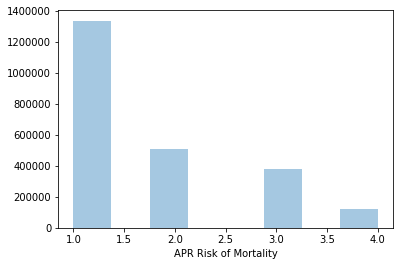

In [7]:
# Visual exploration of the column

import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.distplot(df['APR Risk of Mortality'], kde= False, bins= 8);

plt.rcParams['figure.dpi']= 150

My problem is a multi-class classification

In [8]:
# Distribution of target classes

df['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

The majority class (1) for my target is is 57%. <br>
I will use accuracy and average weighted f1 score as my evaluation metrics
- Average f1-scores are used for multi-class targets
- Weighted average f1-score will account for the label inbalance in my target

I will use a random split to train/validate/test my data as all observations are within the same year. <br>

## Feature Exploration

**Features to exclude** <br>
Not applicable to target (Either unique identifier or information gathered at the end of a patients treatment which is not useful as the model needs to be applied earlier)
- Operating Certificate Number (Unique ID for the hospital)
- Patient Disposition (Destination upon discharge)
- Discharge year (The entire dataset is for the year 2017) 
- Total charges (Information not collected until the end of treatment)
- Total cost (Information not collected until the end of treatment)
- Length of stay (only known at the end of treatment)
- Birth weight (only applicable to newborns)


Redundant: All of the codes have a description column. I will pull them out as a reference table, but for my model they are redundant.
- CCS Diagnosis Description
- CCS Procedure Description
- APR DRG Description
- APR MDC Description
- CCS Diagnosis Code is the same as APR DRG Code


Potential data leakage:
- APR Severity of Illness code (Might have a direct correlation to APR Risk of Mortality)
    - Every time there is a 0 for APR Severity of Illness Code, there is a np.nan for APR Risk of Mortality
    - Upon further exploration below, I have decided to omit this column as 60% of the time it is the exact same value as APR Risk of Mortality

## Reference Tables
- Matches descriptions with codes

In [9]:
# Create a reference table for codes and their descriptions
# We will be dropping the descriptions

# CCS Diagnosis
codes_diagnosis = df.groupby('CCS Diagnosis Description')['CCS Diagnosis Code'].mean()
codes_diagnosis = pd.DataFrame(codes_diagnosis)

# CCS Procedure
codes_procedure = df.groupby('CCS Procedure Description')['CCS Procedure Code'].mean()
codes_procedure = pd.DataFrame(codes_procedure)

# APR DRG
codes_drg = df.groupby('APR DRG Description')['APR DRG Code'].mean()
codes_drg = pd.DataFrame(codes_drg)

# APR MDC
codes_mdc = df.groupby('APR MDC Description')['APR MDC Code'].mean()
codes_mdc = pd.DataFrame(codes_mdc)

# APR Severity of Illness
codes_illness = df.groupby('APR Severity of Illness Description')['APR Severity of Illness Code'].mean()
codes_illness = pd.DataFrame(codes_illness)

In [136]:
# # Saving Reference table to use in my webb app
# codes_drg.to_csv('diagnosis_codes.csv')

In [ ]:
# # Saving Reference table to use in my webb app
# codes_procedure.to_csv('procedure_codes.csv')

## Initial Data Cleaning

In [10]:
# Change pandas display so you can see all of the columns at once

pd.set_option('display.max_columns', 25)

In [11]:
# Drop unnecessary features as commented above

df_cleaned = df.drop([
    'Operating Certificate Number',
    'Patient Disposition',
    'Discharge Year',
    'CCS Diagnosis Description',
    'CCS Procedure Description',
    'APR DRG Description',
    'APR MDC Description',
    'Birth Weight',
    'Total Charges',
    'Total Costs',
    'APR Severity of Illness Description',
    'Length of Stay'
],
    axis= 1

)
df_cleaned.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,Elective,659,0,750,19,2,1.0,Medical,Medicare,Medicare,Self-Pay,N,N
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,Emergency,99,108,194,5,3,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,Emergency,161,102,465,11,2,2.0,Medical,Department of Corrections,Self-Pay,NaN,N,N
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,Emergency,238,222,721,18,2,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,Emergency,2,0,720,18,2,1.0,Medical,Department of Corrections,Self-Pay,NaN,N,N


In [12]:
# Look at null values
df_cleaned.isnull().sum()

Hospital Service Area                  5155
Hospital County                        5155
Permanent Facility Id                  5155
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39019
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                   240
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878722
Payment Typology 3                  1737244
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

In [13]:
# Explore missing values in target

missing_illness = df[df['APR Risk of Mortality'].isnull() == True]
missing_illness['Type of Admission'].value_counts(normalize = True)

Newborn      0.745833
Emergency    0.120833
Urgent       0.070833
Elective     0.062500
Name: Type of Admission, dtype: float64

In [14]:
# Drop missing values in target (only 0.01%)
# They were mostly (74.5%) newborn babies which we are not including in our model

df_cleaned.dropna(subset= ['APR Risk of Mortality'], inplace= True)

#### Manually label encode age group so it has an order

In [15]:
# Manually label encode Age Group
# Label encode
df_cleaned['Age Group'] = df_cleaned['Age Group'].replace({
    '0 to 17': 1,
    "18 to 29": 2,
    "30 to 49": 3,
    "50 to 69": 4,
    "70 or Older": 5
})

## Data exploration 

In [16]:
# Look at numeric traits
df_cleaned.describe()

,Permanent Facility Id,Age Group,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,2.338179e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06
mean,1.038966e+03,3.459087e+00,1.898662e+02,1.013940e+02,4.161252e+02,1.031172e+01,2.020953e+00,1.691481e+00
std,7.202033e+02,1.371550e+00,1.649466e+02,8.681344e+01,2.424451e+02,5.899823e+00,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.410000e+02,3.000000e+00,1.010000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.000000e+00
50%,1.097000e+03,4.000000e+00,1.570000e+02,9.800000e+01,3.830000e+02,9.000000e+00,2.000000e+00,1.000000e+00
75%,1.453000e+03,5.000000e+00,2.180000e+02,1.800000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.000000e+00
max,9.431000e+03,5.000000e+00,2.617000e+03,2.310000e+02,9.520000e+02,2.500000e+01,4.000000e+00,4.000000e+00


In [17]:
# Look at categorical traits
df_cleaned.describe(exclude= 'number')

,Hospital Service Area,Hospital County,Facility Name,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,2338179,2338179,2343329,2304316,2343329,2343329,2343329,2343329,2343329,2343329,1464708,606295,2343329,2343329
unique,8,57,211,50,3,4,4,6,2,10,10,10,2,2
top,New York City,Manhattan,Mount Sinai Hospital,112,F,White,Not Span/Hispanic,Emergency,Medical,Medicare,Medicaid,Self-Pay,N,Y
freq,1070407,395687,52335,293826,1296822,1316956,1895507,1500436,1742545,906899,529653,400972,2339978,1373723


In [18]:
# Cycle through columns and look at different label names for spelling mistakes etc...
df_cleaned['Emergency Department Indicator'].value_counts().index.tolist()

['Y', 'N']

In [19]:
# Look at null values, we will need to impute
df_cleaned.isnull().sum()

Hospital Service Area                  5150
Hospital County                        5150
Permanent Facility Id                  5150
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39013
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878621
Payment Typology 3                  1737034
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

### Explore relationship between APR Severity of Illness and target for potential data leakage

In [20]:
# Create subset of just the two columns
data_leak = df_cleaned[['APR Severity of Illness Code', 'APR Risk of Mortality']]
data_leak

,APR Severity of Illness Code,APR Risk of Mortality
0,2,1.0
1,3,2.0
2,2,2.0
3,2,2.0
4,2,1.0
...,...,...
2343564,1,2.0
2343565,2,2.0
2343566,1,1.0
2343567,2,1.0


In [21]:
# Look a statistical information
data_leak.describe()

,APR Severity of Illness Code,APR Risk of Mortality
count,2.343329e+06,2.343329e+06
mean,2.020953e+00,1.691481e+00
std,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00
75%,3.000000e+00,2.000000e+00
max,4.000000e+00,4.000000e+00


In [22]:
# Count how many times they are not equivalent

# Convert APR Risk of Mortality to integer
data_leak['APR Risk of Mortality'] = data_leak['APR Risk of Mortality'].astype(int)

# Pull out subset of when the two columns are not equivalent
subset = data_leak[data_leak['APR Risk of Mortality'] != data_leak['APR Severity of Illness Code']]
subset

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,APR Severity of Illness Code,APR Risk of Mortality
0,2,1
1,3,2
4,2,1
6,2,1
10,2,1
...,...,...
2343561,3,2
2343563,2,1
2343564,1,2
2343567,2,1


In [23]:
# Proportion of when these two columns are the same
1 - len(subset) / len(df_cleaned)

0.5913587037927666

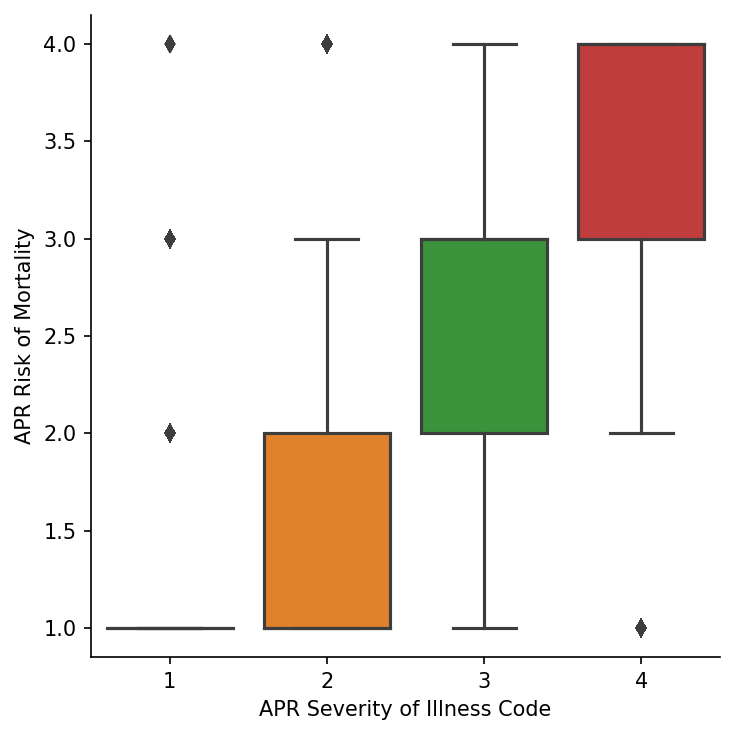

In [24]:
# Visual of relationship
sns.catplot(x= 'APR Severity of Illness Code', y= 'APR Risk of Mortality', kind= 'box', data= data_leak);

**In conclusion I will drop APR Severity of Illness code for two reasons**
- First, it is too similar to the target. 59% of the time they are the exact same value.
- Second, in practice I would want to implement the model before necessarily knowing the severity of the illness. By the time you know the severity of the illness, my model would not provide you with very much additional useful information.

### Explore Redacted Data
- 5150 rows with redacted geographic information
- Labeled 'Redacted for Confidentiality'

In [25]:
# Pull out the redacted information
redacted = df_cleaned[df_cleaned['Facility Name'] == 'Redacted for Confidentiality']
redacted

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
28,NaN,NaN,NaN,Redacted for Confidentiality,1,NaN,F,White,Not Span/Hispanic,Emergency,229,148,315,8,2,1.0,Surgical,Blue Cross/Blue Shield,Self-Pay,NaN,N,N
595,NaN,NaN,NaN,Redacted for Confidentiality,2,NaN,F,White,Not Span/Hispanic,Urgent,181,222,564,14,1,1.0,Medical,Blue Cross/Blue Shield,Medicaid,NaN,Y,N
839,NaN,NaN,NaN,Redacted for Confidentiality,2,NaN,F,Black/African American,Not Span/Hispanic,Emergency,177,127,544,14,1,1.0,Surgical,Medicaid,Medicaid,Self-Pay,Y,N
2227,NaN,NaN,NaN,Redacted for Confidentiality,1,NaN,F,Other Race,Spanish/Hispanic,Emergency,195,126,560,14,2,1.0,Medical,Medicaid,NaN,NaN,Y,Y
2723,NaN,NaN,NaN,Redacted for Confidentiality,3,NaN,F,Black/African American,Not Span/Hispanic,Emergency,180,123,545,14,1,1.0,Surgical,Medicaid,NaN,NaN,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342722,NaN,NaN,NaN,Redacted for Confidentiality,1,NaN,M,White,Spanish/Hispanic,Newborn,218,115,640,15,1,1.0,Medical,Medicaid,NaN,NaN,N,N
2342742,NaN,NaN,NaN,Redacted for Confidentiality,5,NaN,U,White,Not Span/Hispanic,Emergency,99,0,194,5,2,2.0,Medical,Medicare,Medicaid,NaN,N,Y
2342768,NaN,NaN,NaN,Redacted for Confidentiality,3,NaN,M,Black/African American,Not Span/Hispanic,Emergency,83,0,53,1,1,1.0,Medical,Medicaid,NaN,NaN,N,Y
2342862,NaN,NaN,NaN,Redacted for Confidentiality,3,NaN,F,White,Not Span/Hispanic,Emergency,178,127,544,14,2,1.0,Surgical,Medicaid,Medicaid,NaN,Y,Y


In [26]:
# Explore redacted numeric features
redacted.describe()

,Permanent Facility Id,Age Group,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,0.0,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,NaN,2.626408,196.830097,110.588544,526.164854,13.269320,1.726602,1.329903
std,NaN,0.964027,125.279172,67.198097,158.935758,3.970063,0.755514,0.659645
min,NaN,1.000000,2.000000,0.000000,4.000000,1.000000,1.000000,1.000000
25%,NaN,2.000000,177.000000,87.000000,544.000000,14.000000,1.000000,1.000000
50%,NaN,3.000000,179.000000,126.000000,545.000000,14.000000,2.000000,1.000000
75%,NaN,3.000000,180.000000,131.000000,564.000000,14.000000,2.000000,1.000000
max,NaN,5.000000,2617.000000,231.000000,952.000000,25.000000,4.000000,4.000000


In [27]:
# Explore redacted categorical features
redacted.describe(exclude = 'number')

,Hospital Service Area,Hospital County,Facility Name,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,0,0,5150,0,5150,5150,5150,5150,5150,5150,2519,877,5150,5150
unique,0,0,1,0,3,4,4,6,2,10,10,7,2,2
top,NaN,NaN,Redacted for Confidentiality,NaN,F,Other Race,Not Span/Hispanic,Emergency,Surgical,Medicaid,Medicaid,Self-Pay,Y,Y
freq,NaN,NaN,5150,NaN,4215,1788,2755,3873,2693,2671,1409,705,3351,3559


In [28]:
# 65% of the redacted information was because they were abortions
# Will drop these rows because abortion indicator has zero effect on my model
redacted['Abortion Edit Indicator'].value_counts(normalize= True)

Y    0.65068
N    0.34932
Name: Abortion Edit Indicator, dtype: float64

In [29]:
# Look at the distribution of various features within redacted subset
# Looking to see if there is a specific reason these were redacted

redacted['APR Severity of Illness Code'].value_counts(normalize= True)

1    0.436505
2    0.423301
3    0.117282
4    0.022913
Name: APR Severity of Illness Code, dtype: float64

Will drop rows with redacted information because 65% are redacted due to being an abortion (abortion indicator has zero impact on my model). The rest maintain a normal distribution throughout the features so I will not be losing any information by dropping them (0.078% of observations). 

In [30]:
# Drop redacted observations - Where Hospital County is null
df_cleaned.dropna(subset= ['Hospital County'], inplace= True)

In [31]:
# Check that redacted observations were dropped
print(df_cleaned.shape)
df_cleaned.isnull().sum()

(2338179, 22)


Hospital Service Area                     0
Hospital County                           0
Permanent Facility Id                     0
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   33863
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   875990
Payment Typology 3                  1732761
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

### Clean zip code
- I want to replace missing zip codes with the most frequent for the county that the hospital is located in

In [32]:
# Define a function that will take the most frequent 

def manual_mode(X):
    manmode = X.copy()
    try: manmode = manmode.value_counts().index[0]
    except: pass
    return manmode

In [33]:
# Use the previously defined function to fill null values with most frequent zip code grouped by Hospital County

df_cleaned['Zip Code - 3 digits'] = df_cleaned['Zip Code - 3 digits'].fillna(df_cleaned.groupby('Hospital County')['Zip Code - 3 digits'].transform(manual_mode))


In [34]:
# Look at what is left to clean
df_cleaned.isnull().sum()

Hospital Service Area                     0
Hospital County                           0
Permanent Facility Id                     0
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                       0
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   875990
Payment Typology 3                  1732761
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

### Clean Payment Typology 2 and 3
- Replace missing values with 'None'
- These patients only used one type of payment, didn't need type 2 or 3

In [35]:
# Replace missing values of Payment Typology 2 and 3 with 'None', they only used one type of payment

df_cleaned['Payment Typology 2']= df_cleaned['Payment Typology 2'].replace({np.nan: 'None'})
df_cleaned['Payment Typology 3']= df_cleaned['Payment Typology 3'].replace({np.nan: 'None'})

In [36]:
# Check which null values are left to clean

df_cleaned.isnull().sum()

Hospital Service Area               0
Hospital County                     0
Permanent Facility Id               0
Facility Name                       0
Age Group                           0
Zip Code - 3 digits                 0
Gender                              0
Race                                0
Ethnicity                           0
Type of Admission                   0
CCS Diagnosis Code                  0
CCS Procedure Code                  0
APR DRG Code                        0
APR MDC Code                        0
APR Severity of Illness Code        0
APR Risk of Mortality               0
APR Medical Surgical Description    0
Payment Typology 1                  0
Payment Typology 2                  0
Payment Typology 3                  0
Abortion Edit Indicator             0
Emergency Department Indicator      0
dtype: int64

## Split into train/val/test using random split

In [37]:
from sklearn.model_selection import train_test_split

# Split train data into train and test, 80/20 split

train, test = train_test_split(df_cleaned, train_size=0.85, test_size=0.15, 
                              stratify=df_cleaned['APR Risk of Mortality'], random_state=42)

# Then split train into train and validate
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['APR Risk of Mortality'], random_state=42)

train.shape, val.shape, test.shape

((1589961, 22), (397491, 22), (350727, 22))

## Baseline model: 
Majority class (1, minor risk) is 57%

In [38]:
# Distribution of target
df_cleaned['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.570766
2.0    0.216905
3.0    0.161616
4.0    0.050714
Name: APR Risk of Mortality, dtype: float64

In [39]:
# Baseline classification report
from sklearn.metrics import classification_report

# Looking at accuracy and weighted average f1-score as evaluation metrics 
guess= [1] * len(df_cleaned)

print(classification_report(df_cleaned['APR Risk of Mortality'], guess))

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       0.57      1.00      0.73   1334553
         2.0       0.00      0.00      0.00    507162
         3.0       0.00      0.00      0.00    377886
         4.0       0.00      0.00      0.00    118578

    accuracy                           0.57   2338179
   macro avg       0.14      0.25      0.18   2338179
weighted avg       0.33      0.57      0.41   2338179



## First Model

In [40]:
# Set features and target
# Define target vector and feature matrices

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [41]:
# Install category encoders in anaconda environment
# conda install -c conda-forge category_encoders

In [42]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline (encode, standardize, model)
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 10, n_estimators= 10)
)

# Fit on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.68056071815598
Validation Accuracy: 0.6789210321743134


#### First model evaluation metric results
Train Accuracy: 0.6816669103706833 <br>
Validation Accuracy: 0.6794078811946803

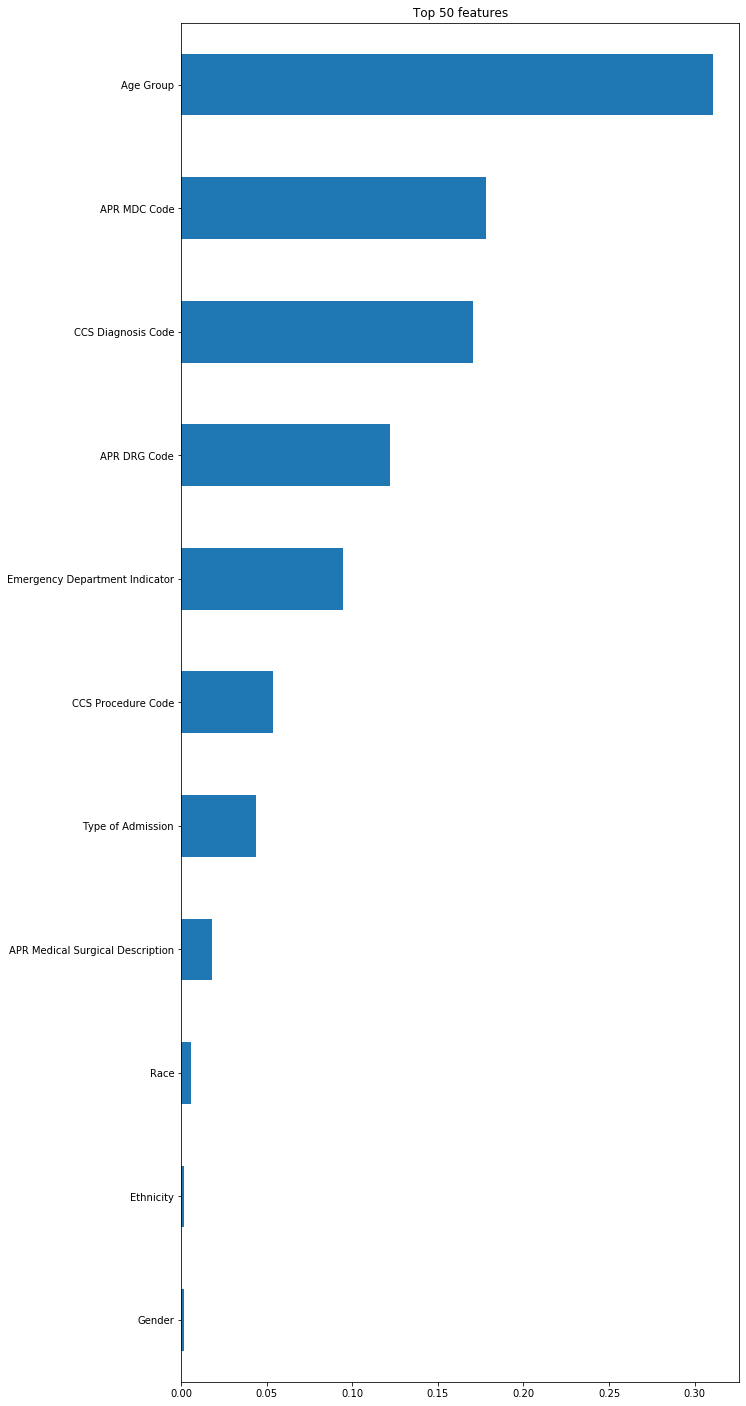

In [43]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

### Scores for Model 1

In [44]:
# Look at precision and recall for each class
# Using accuracy and weighted average f1-score as evaluation metrics

from sklearn.metrics import classification_report

# Make predictions
y_pred= pipeline.predict(X_val)

# Print scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.79      0.92      0.85    226874
         2.0       0.45      0.38      0.41     86218
         3.0       0.47      0.40      0.43     64241
         4.0       0.62      0.20      0.31     20158

    accuracy                           0.68    397491
   macro avg       0.58      0.47      0.50    397491
weighted avg       0.65      0.68      0.66    397491



Remember that the baseline model had an accuracy of 57% with a weighted average f1-score of 0.42

## Model 2
- Include all of the features except for geographic data

In [45]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Payment Typology 2',
    'Payment Typology 3',
    'Abortion Edit Indicator',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [46]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.772727758731189
Validation Accuracy: 0.6932383374717919


### Scores for Model 2

In [47]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.90      0.86    226874
         2.0       0.46      0.42      0.44     86218
         3.0       0.48      0.45      0.47     64241
         4.0       0.61      0.24      0.35     20158

    accuracy                           0.69    397491
   macro avg       0.59      0.51      0.53    397491
weighted avg       0.68      0.69      0.68    397491



Model 2 improved the evaluation scores 2-3 points each.

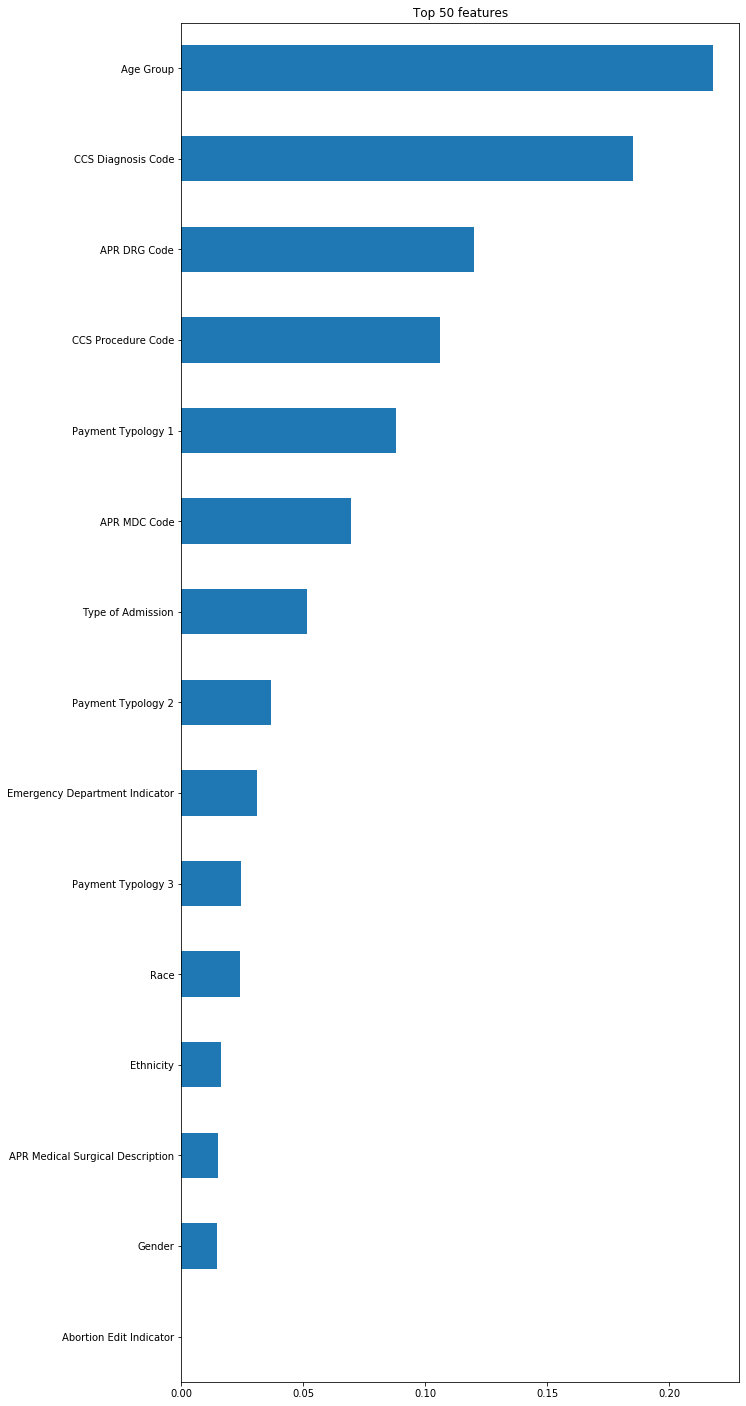

In [48]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

#### Permutation importances

In [49]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputing into PermutationImportance

# Create pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
# Install eli5 on anaconda environment
# conda install -c conda-forge eli5

In [51]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [52]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.0917 ± 0.0009,Age Group
0.0469 ± 0.0009,CCS Diagnosis Code
0.0283 ± 0.0007,CCS Procedure Code
0.0265 ± 0.0004,APR DRG Code
0.0214 ± 0.0005,APR MDC Code
0.0135 ± 0.0004,APR Medical Surgical Description
0.0099 ± 0.0004,Payment Typology 1
0.0090 ± 0.0009,Emergency Department Indicator
0.0077 ± 0.0004,Type of Admission
0.0024 ± 0.0002,Payment Typology 2


## Model 3
- Clean up feature selection. Don't include ones that have low importance in the model
- Don't include ones that are supersets of other features

In [54]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Type of Admission',
    'APR DRG Code',
    'CCS Procedure Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [55]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.725675032280666
Validation Accuracy: 0.6889187428143028


Scores

In [56]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.90      0.86    226874
         2.0       0.46      0.41      0.43     86218
         3.0       0.47      0.45      0.46     64241
         4.0       0.59      0.28      0.38     20158

    accuracy                           0.69    397491
   macro avg       0.58      0.51      0.53    397491
weighted avg       0.67      0.69      0.68    397491



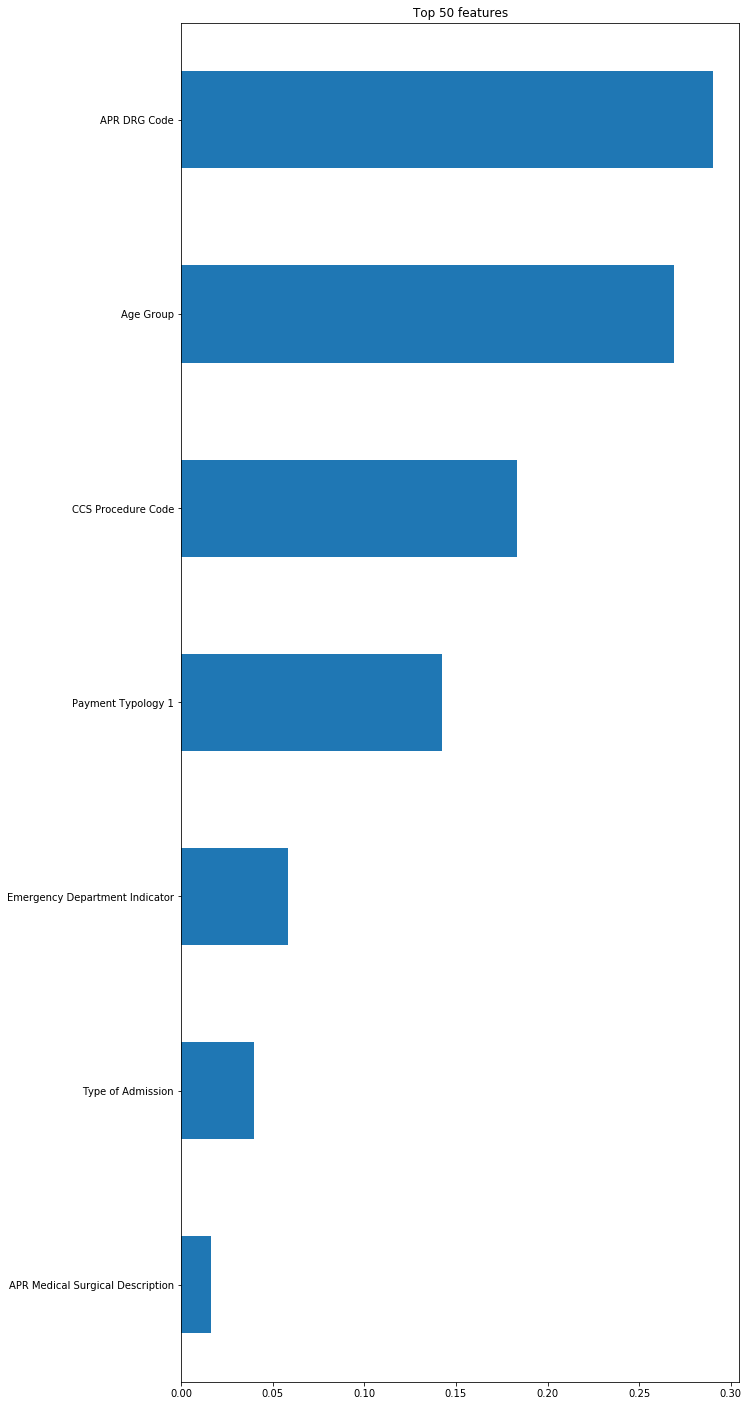

In [57]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [58]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputting into PermutationImportance

# Create processor pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [59]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [60]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.1107 ± 0.0014,Age Group
0.0891 ± 0.0012,APR DRG Code
0.0739 ± 0.0008,CCS Procedure Code
0.0346 ± 0.0008,APR Medical Surgical Description
0.0197 ± 0.0003,Type of Admission
0.0159 ± 0.0005,Emergency Department Indicator
0.0148 ± 0.0009,Payment Typology 1


**Hyperparameter tuning with RandomizedSearchCV**

In [62]:
# Import
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Set range of different parameters for CV to try
param_distributions = {
    'randomforestclassifier__max_depth': [10, 15, 20, 25, 30],
    'randomforestclassifier__n_estimators': randint(5, 100)
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

search.fit(X_train, y_train);

KeyboardInterrupt: 

In [ ]:
# Return best parameters and score
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

In [ ]:
# Using best parameters from RandomizedCVSearch

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 15, n_estimators= 61, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

In [ ]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

### Confusion Matrix

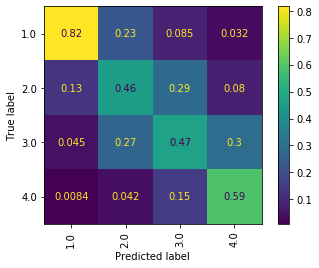

In [61]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix

# Plot
plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation= 'vertical', normalize= 'pred')

# Enlarge
plt.rcParams['figure.dpi']= 200

## Test Data using Final Model

In [62]:
# Best model (Model 3)

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))
print('Test Accuracy:', pipeline.score(X_test, y_test))

Train Accuracy: 0.725675032280666
Validation Accuracy: 0.6889187428143028
Test Accuracy: 0.6884072227116818


In [63]:
# Make predictions using test data
y_pred= pipeline.predict(X_test)

# Print recall, precision and f1 scores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.90      0.86    200183
         2.0       0.46      0.41      0.43     76074
         3.0       0.47      0.45      0.46     56683
         4.0       0.58      0.28      0.38     17787

    accuracy                           0.69    350727
   macro avg       0.58      0.51      0.53    350727
weighted avg       0.67      0.69      0.68    350727



#### Test Data
***Accuracy: 0.69 <br>
Weighted average f1 score: 0.68***

### Partial Dependence Plot - 1 Isolated Variable

In [ ]:
# # Install pdpbox in anaconda environment
# conda install -c conda-forge pdpbox

In [64]:
# Import Partial Dependence Plot
from pdpbox.pdp import pdp_isolate, pdp_plot

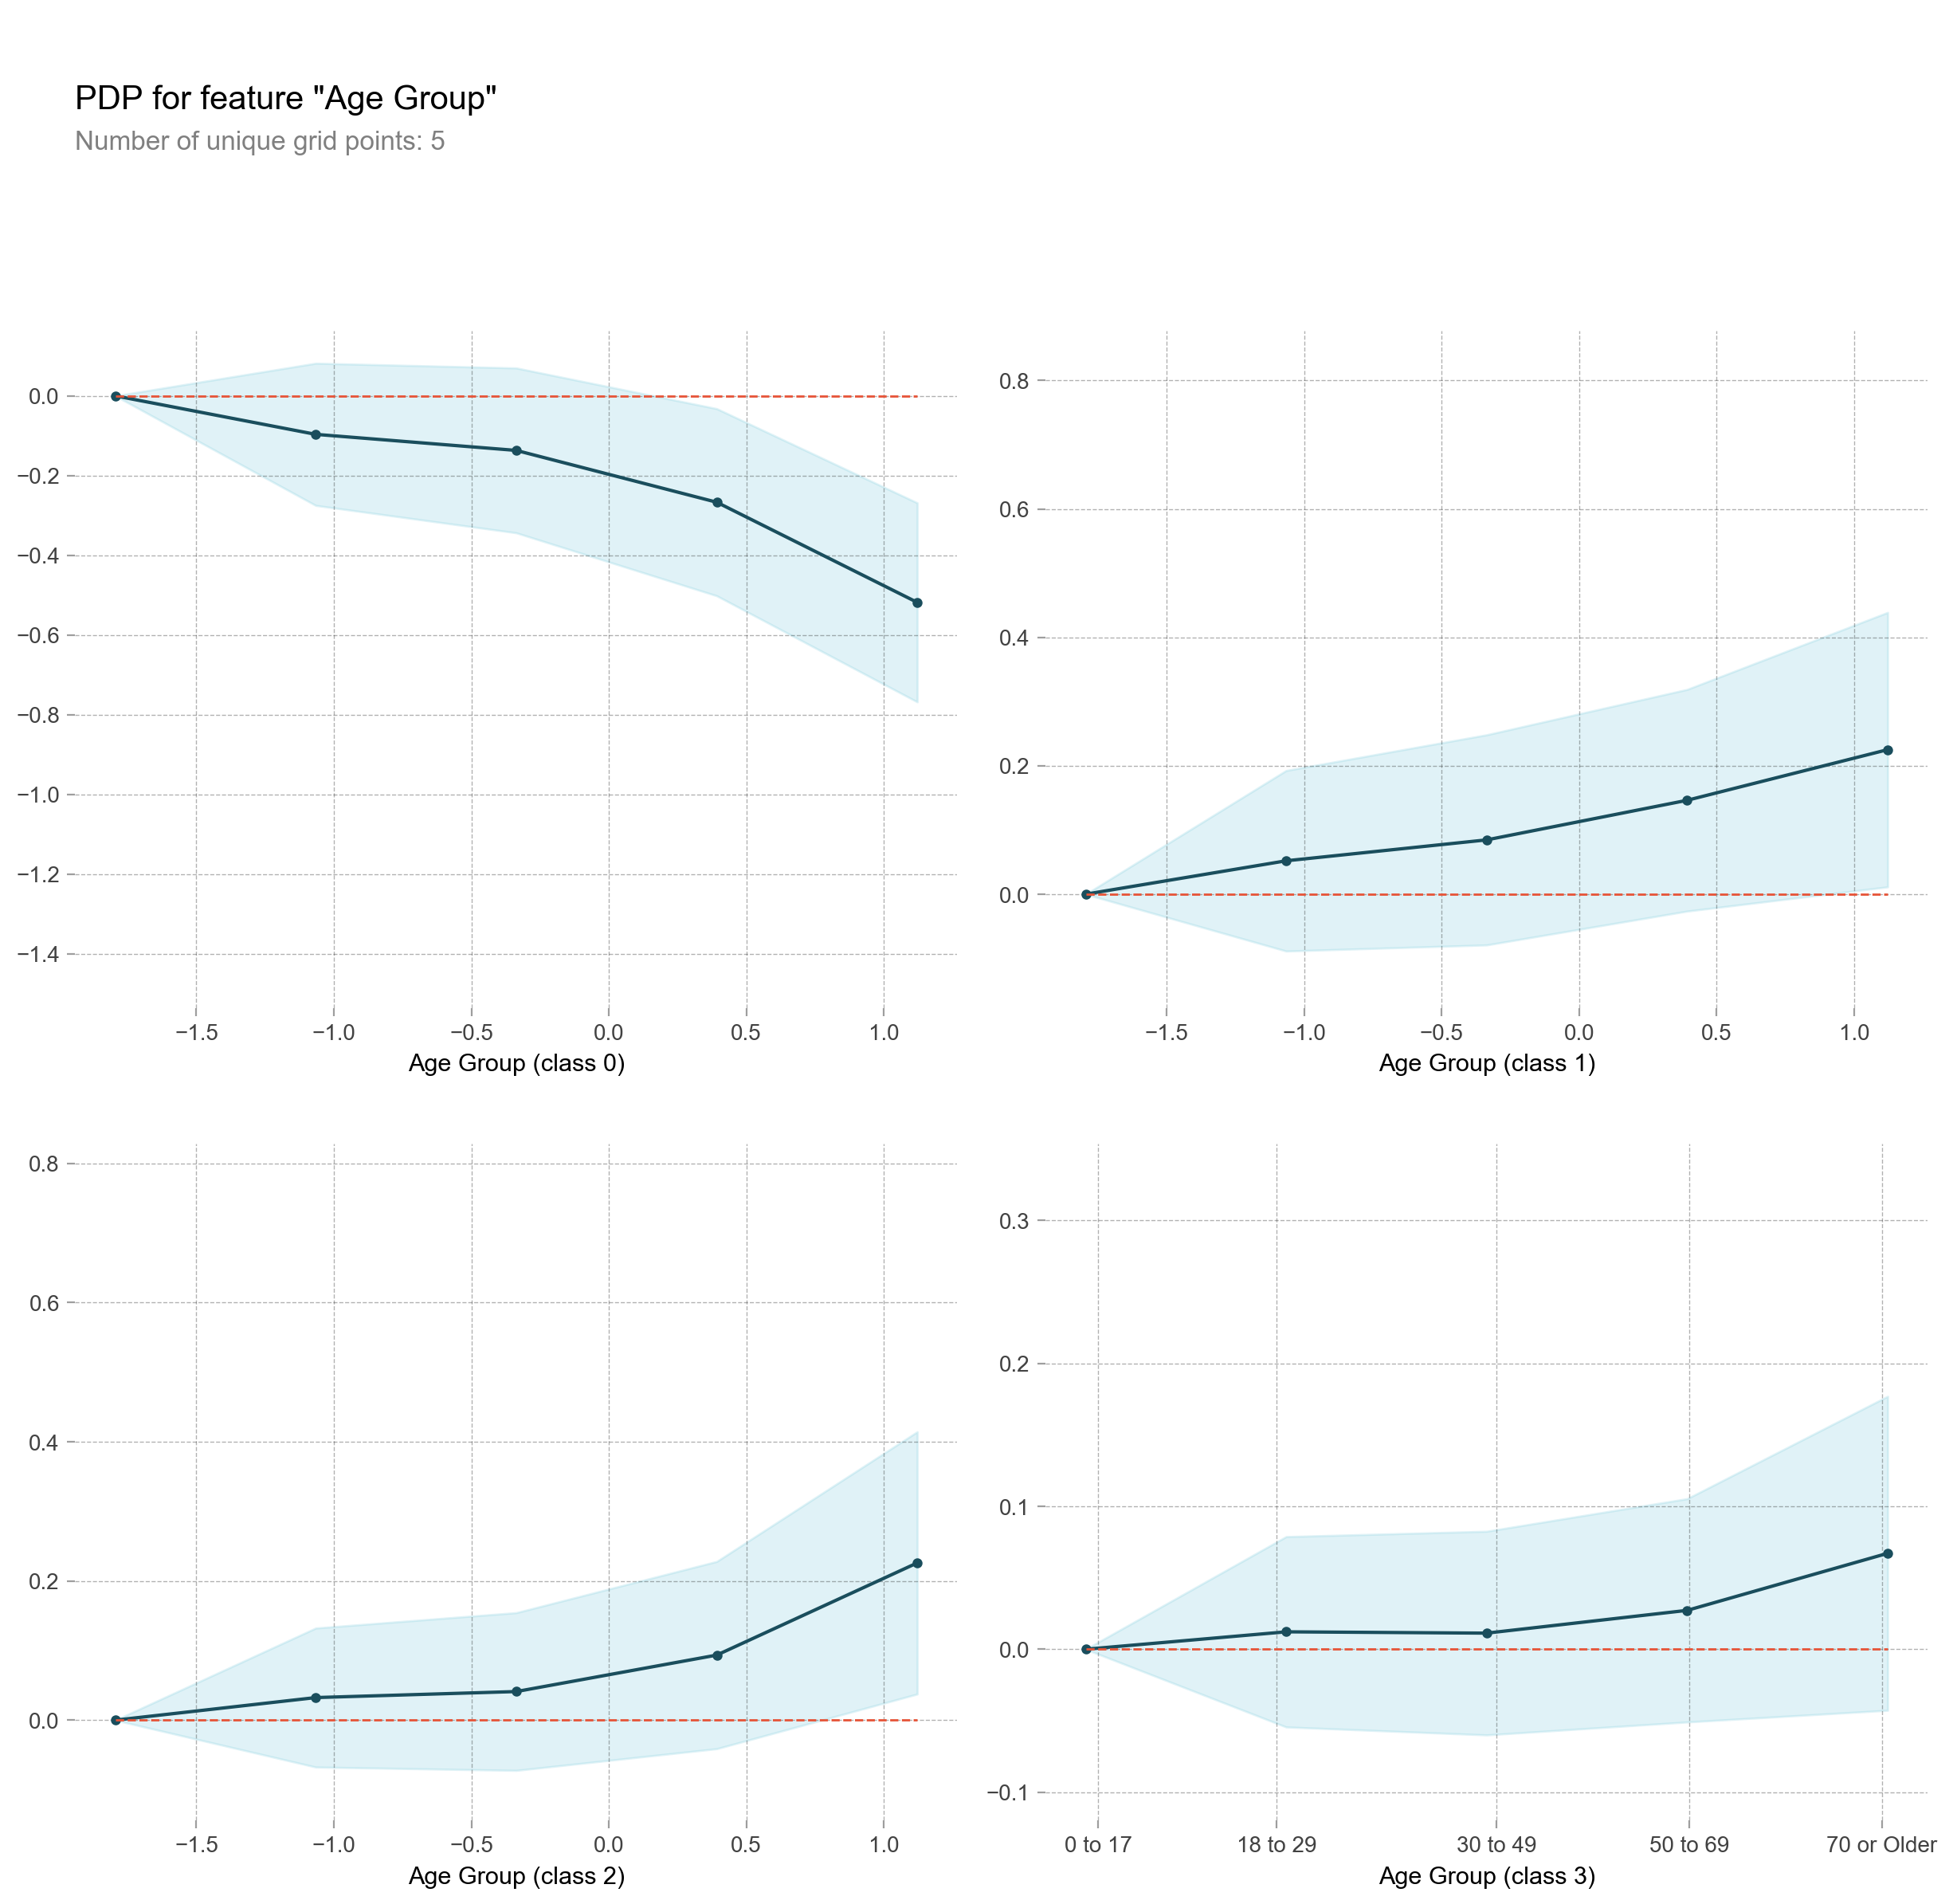

In [65]:
# Choose feature
feature = 'Age Group'

# Set model
isolated = pdp_isolate(
    model= model,
    dataset= pd.DataFrame(X_val_transformed, columns= X_val.columns),
    model_features= X_val.columns,
    feature = feature
)

# View plot
pdp_plot(isolated, feature)

# Change tick labels
plt.xticks([-1.75, -1.1, -0.3, 0.4, 1.1], ['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']);

### PDP with Two Interacting Variables

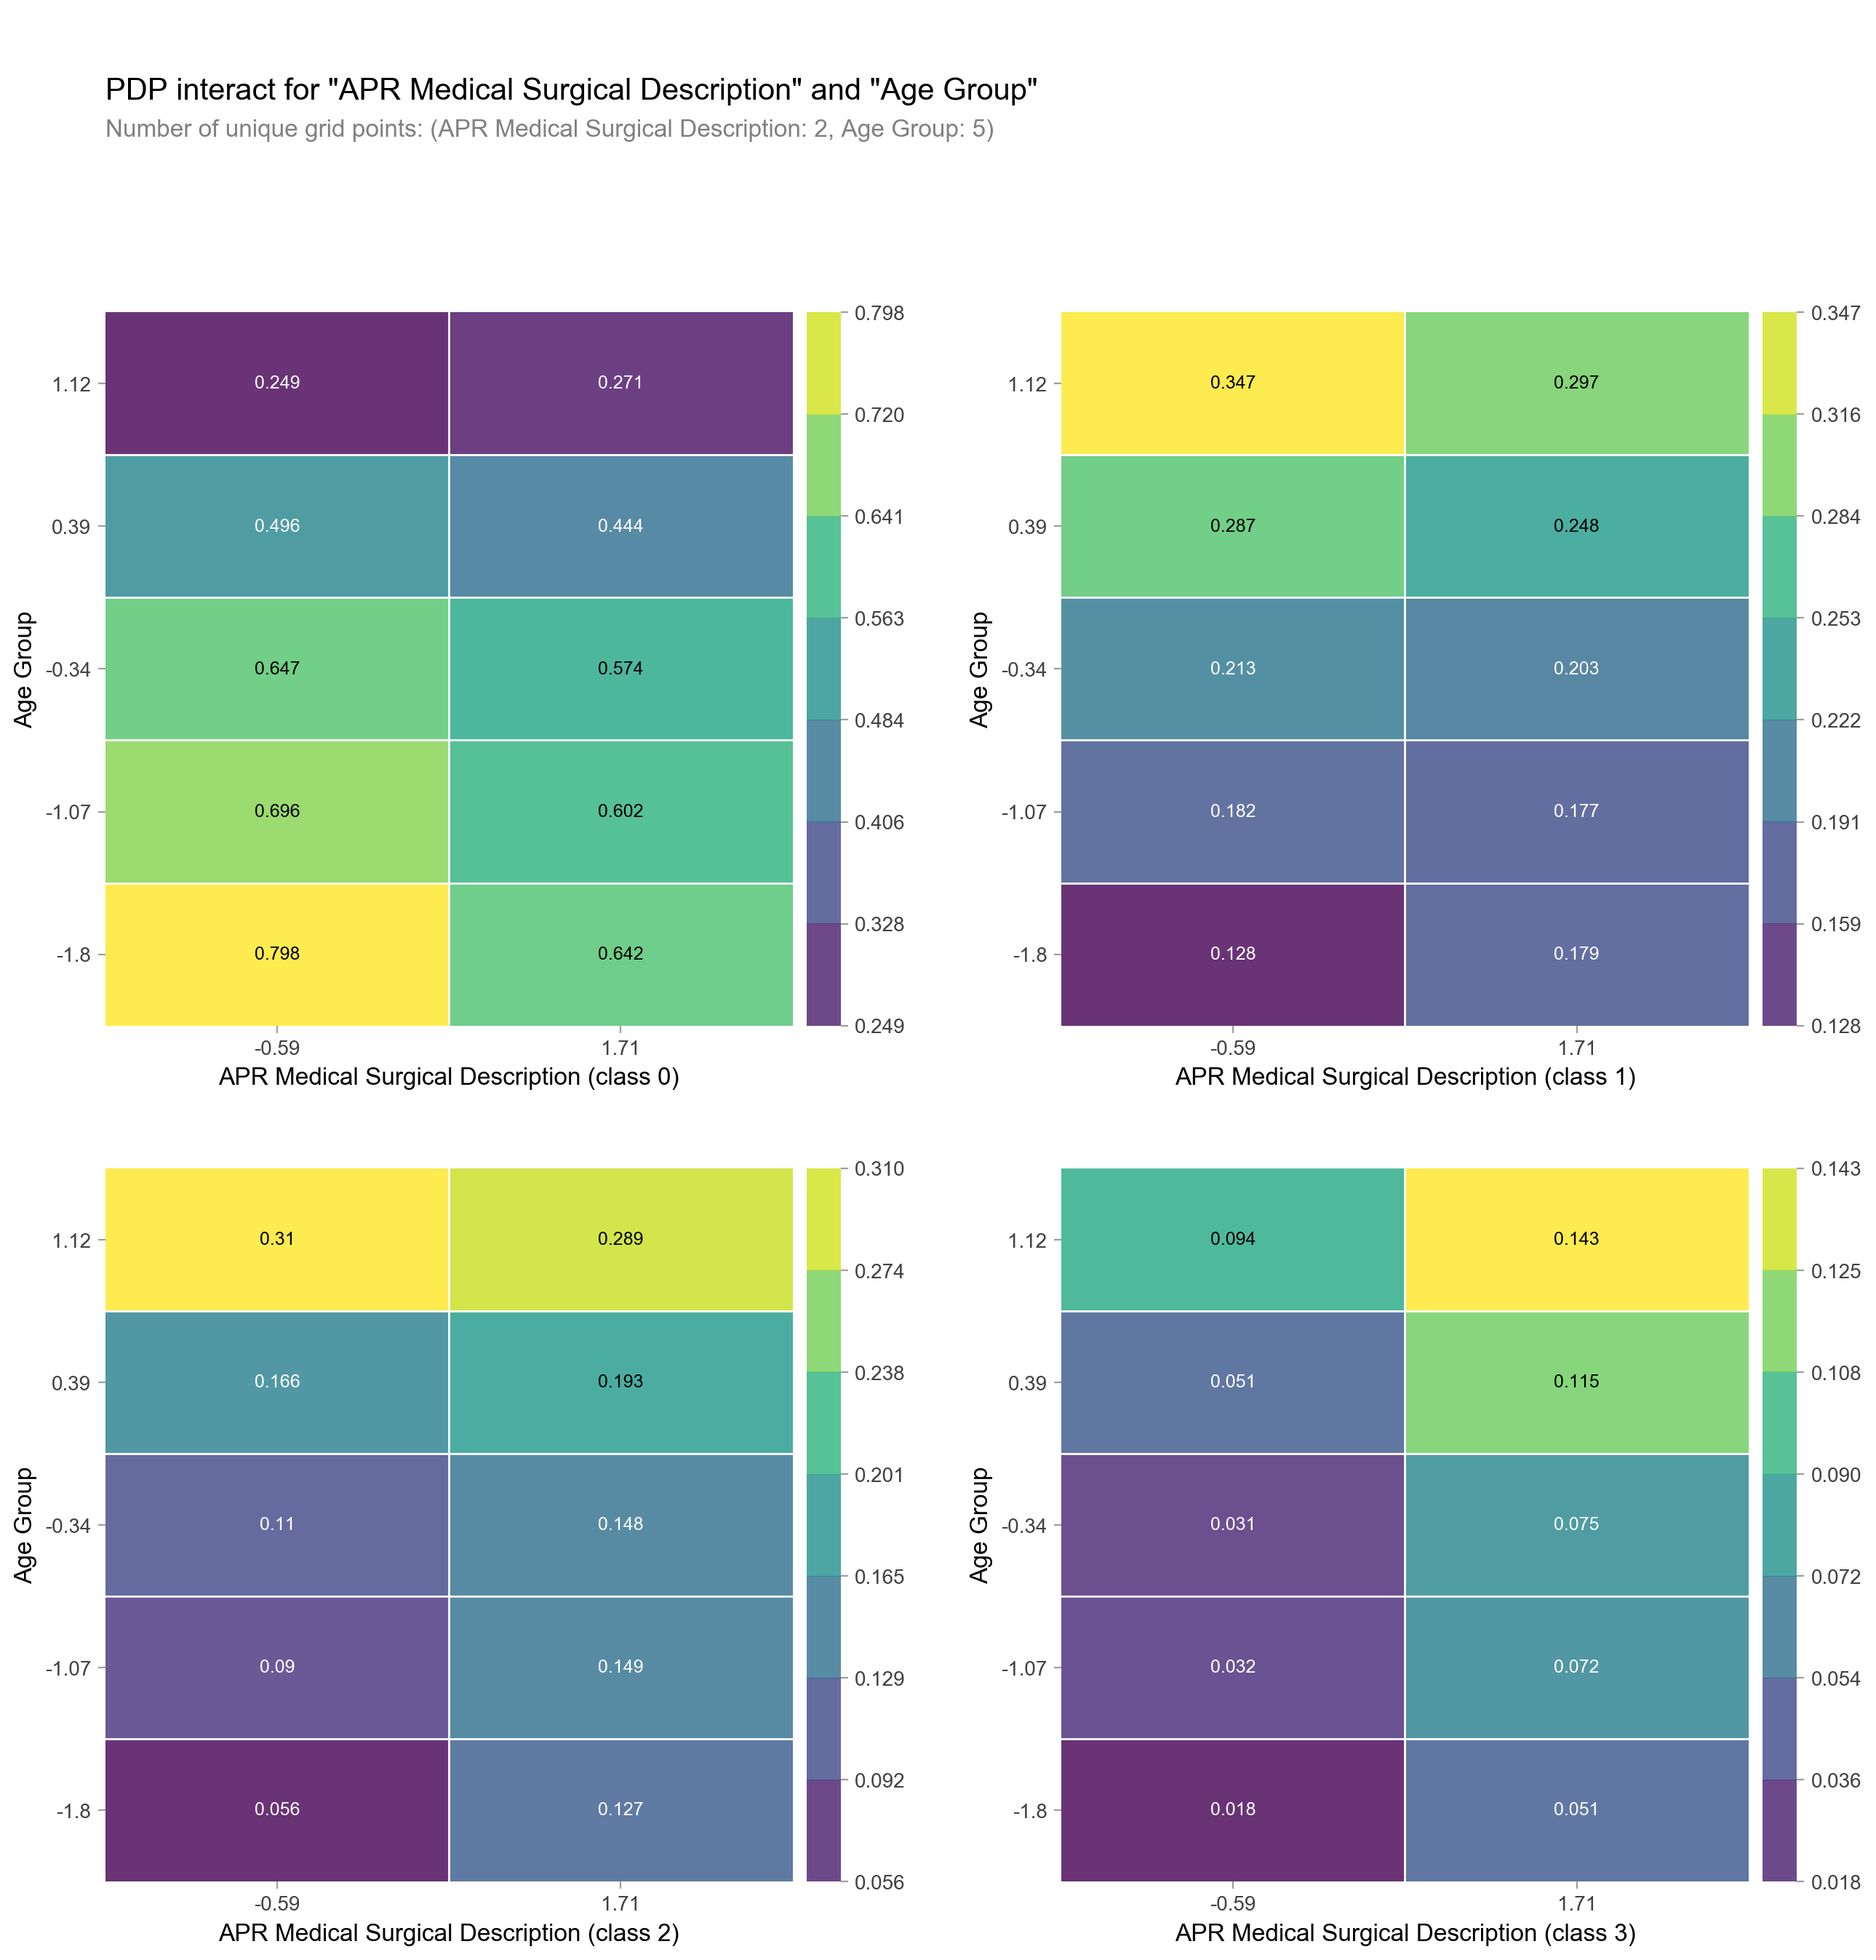

In [67]:
# Partial Dependence Plot with 2 fetures

# Import
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Define features you want to examine
features = ['APR Medical Surgical Description', 'Age Group']

# Create Model
interaction = pdp_interact(
    model= model, 
    dataset= pd.DataFrame(X_val_transformed, columns= X_val.columns),
    model_features= X_val.columns,
    features= features
)

# Plot Results
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);



### Shapley Force Plot

In [ ]:
# Install shap in anaconda environment
# conda install -c conda-forge shap

In [68]:
# Import shap
import shap

In [94]:
# Features and target info of random test patient
# Include actual APR Risk of Mortality so we can compare it against the models predictions

test_patient= test[['APR Risk of Mortality', 'Age Group', 'Type of Admission', 'APR DRG Code','CCS Procedure Code', 'APR Medical Surgical Description', 'Payment Typology 1', 'Emergency Department Indicator']]
test_patient.iloc[[221]]

,APR Risk of Mortality,Age Group,Type of Admission,APR DRG Code,CCS Procedure Code,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator
794812,3.0,5,Emergency,139,0,Medical,Medicare,Y
1874914,2.0,5,Emergency,420,177,Medical,Medicare,Y
1879313,4.0,4,Emergency,1,176,Surgical,Medicaid,Y
1481542,3.0,5,Emergency,383,0,Medical,Medicare,Y
1438621,3.0,5,Elective,302,152,Surgical,Medicare,N


In [69]:
# Pick random row of test to examine
row= X_test.iloc[[221]]
row

,Age Group,Type of Admission,APR DRG Code,CCS Procedure Code,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator
174602,1,Emergency,254,0,Medical,Medicaid,Y


In [71]:
# For Minor Risk of Mortality class

# Get Shapley values
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

# Plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit',
)

In [72]:
# For Moderate Risk of Mortality class

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit')

In [73]:
# For Major Risk of Mortality class

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2], 
    shap_values=shap_values[2], 
    features=row, 
    link='logit')

In [74]:
# For Extreme Risk of Mortality class

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[3], 
    shap_values=shap_values[3], 
    features=row, 
    link='logit')

### Linear Classification Model
- Logistic regression
- SVC (Support Vector Classification)

**Support Vector Machine**

In [65]:
# Run svm on a smaller sample of data - 10% of tain and val data sets

# Create Sample
train_sample = train.sample(frac= .1)
val_sample = val.sample(frac= .1)

# Set Target
target = 'APR Risk of Mortality'


# Set Features
features = [
    'Age Group',
    'Type of Admission',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Emergency Department Indicator',
]

# Define feature matricies and target vectors
X_train_sample= train_sample[features]
y_train_sample= train_sample[target]

X_val_sample= val_sample[features]
y_val_sample= val_sample[target]

In [66]:
# Import Support Vector Machine
from sklearn import svm

In [67]:
# Create processor pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the sample data
X_train_transformed = processor.fit_transform(X_train_sample)
X_val_transformed = processor.transform(X_val_sample)

In [68]:
# Instantiate Support Vector Classification
svm_svc = svm.SVC(random_state= 42)

# Fit SVC to transformed, sample data
svm_svc.fit(X_train_transformed, y_train_sample)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [69]:
# Make predictions
y_pred= svm_svc.predict(X_val_transformed)

# Print recall, precision and f1 scores
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

         1.0       0.73      0.93      0.82     22730
         2.0       0.42      0.29      0.34      8592
         3.0       0.42      0.30      0.35      6435
         4.0       0.58      0.02      0.04      1992

    accuracy                           0.64     39749
   macro avg       0.53      0.38      0.39     39749
weighted avg       0.60      0.64      0.60     39749



**Linear Support Vector Machine Model**

In [70]:
# Import Support Vector Machine
from sklearn import svm

# Instantiate model
linear_svc = svm.LinearSVC(random_state= 42)

# Fit model
linear_svc.fit(X_train_transformed, y_train_sample)

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [71]:
# Make predictions
y_pred= linear_svc.predict(X_val_transformed)

# Print recall, precision and f1 scores
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

         1.0       0.62      0.88      0.73     22730
         2.0       0.34      0.29      0.32      8592
         3.0       0.16      0.00      0.01      6435
         4.0       0.00      0.00      0.00      1992

    accuracy                           0.57     39749
   macro avg       0.28      0.29      0.26     39749
weighted avg       0.46      0.57      0.49     39749



/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Logistic Regression Model**

In [72]:
# Import
from sklearn.linear_model import LogisticRegression

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.6020034453675279
Validation Accuracy: 0.6026476071156328


In [73]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.67      0.91      0.77    226874
         2.0       0.35      0.18      0.24     86218
         3.0       0.39      0.25      0.31     64241
         4.0       0.43      0.03      0.05     20158

    accuracy                           0.60    397491
   macro avg       0.46      0.34      0.34    397491
weighted avg       0.54      0.60      0.55    397491



Logistic regression returned best evaluation metrics for a linear model.

### XGBoost

In [53]:
# conda install -c conda-forge xgboost

In [387]:
# Import
from xgboost import XGBClassifier

# Create pipeline using XGBoostClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_estimators= 30, random_state= 42, n_jobs= -1)
)

# Fit pipeline to train data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Race', 'Ethnicity',
                                      'Type of Admission',
                                      'APR Medical Surgical Description',
                                      'Payment Typology 1',
                                      'Payment Typology 2',
                                      'Payment Typology 3',
                                      'Abortion Edit Indicator',
                                      'Emergency Department Indicator'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Gender',...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
           

In [388]:
# Import
from sklearn.metrics import accuracy_score

# Make predictions
y_pred= pipeline.predict(X_val)

# Print error metric
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6566337351034363


In [389]:
# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.74      0.93      0.83    226874
         2.0       0.42      0.36      0.39     86218
         3.0       0.45      0.27      0.34     64241
         4.0       0.75      0.11      0.20     20158

    accuracy                           0.66    397491
   macro avg       0.59      0.42      0.44    397491
weighted avg       0.63      0.66      0.62    397491



XGBoost did not improve the evaluation metrics from Random Forest

#### Code to Create Web App

In [87]:
# Pickle the model and dump locally

from joblib import dump
dump(pipeline, 'pipeline.joblib', compress= True)

['pipeline.joblib']

In [86]:
# Retrieve version types to install in pipenv shell on local computer
import joblib
import sklearn
import category_encoders as ce

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')

joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.1.0
